In [13]:
import numpy as np
import perceval as pcvl
import perceval.components as comp
import sympy as sp
from perceval.components import catalog
from perceval.converters import QiskitConverter
from perceval.algorithm import Analyzer, Sampler
from perceval.rendering.circuit import SymbSkin, PhysSkin

my_genDisc = pcvl.Circuit(8)



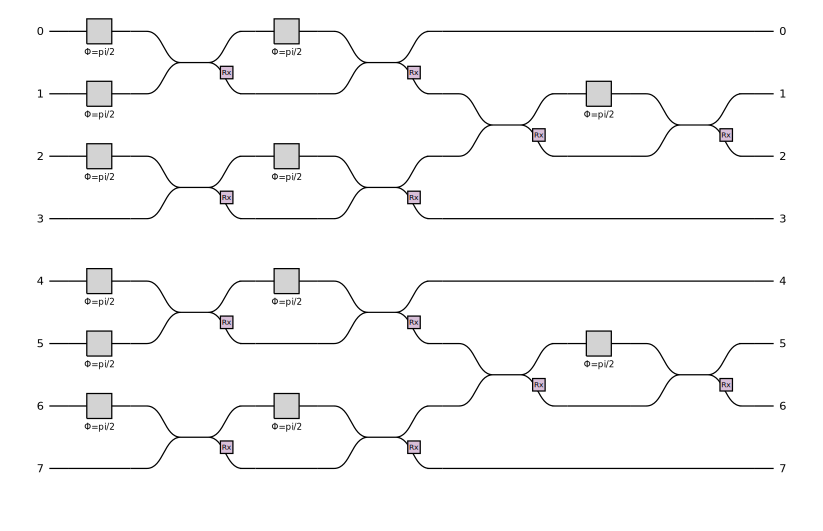

In [14]:
# list lines with phase shift
list = [1,2,3,5,6,7]
for i in list:
    my_genDisc.add(i, comp.PS(sp.pi/2))

my_genDisc.add((1, 2), comp.BS())
my_genDisc.add((5, 6), comp.BS())

# list lines with phase shift
list = [1,5]
for i in list:
    my_genDisc.add(i, comp.PS(sp.pi/2))

my_genDisc.add((1, 2), comp.BS())
my_genDisc.add((5, 6), comp.BS())

my_genDisc.add((0, 1), comp.BS())
my_genDisc.add((2, 3), comp.BS())
my_genDisc.add((4, 5), comp.BS())
my_genDisc.add((6, 7), comp.BS())

# list lines with phase shift
list = [0,2,4,6]
for i in list:
    my_genDisc.add(i, comp.PS(sp.pi/2))

my_genDisc.add((0, 1), comp.BS())
my_genDisc.add((2, 3), comp.BS())
my_genDisc.add((4, 5), comp.BS())
my_genDisc.add((6, 7), comp.BS())

# list lines with phase shift
list = [1,5]
for i in list:
    my_genDisc.add(i, comp.PS(sp.pi/2))

my_genDisc.add((1, 2), comp.BS())
my_genDisc.add((5, 6), comp.BS())

# list lines with phase shift
list = [1,5]
for i in list:
    my_genDisc.add(i, comp.PS(sp.pi/2))
    
my_genDisc.add((1, 2), comp.BS())
my_genDisc.add((5, 6), comp.BS())

# list lines with phase shift
list = [0,2,4,6]
for i in list:
    my_genDisc.add(i, comp.PS(sp.pi/2))

my_genDisc.add((0, 1), comp.BS())
my_genDisc.add((2, 3), comp.BS())
my_genDisc.add((4, 5), comp.BS())
my_genDisc.add((6, 7), comp.BS())

# list lines with phase shift
list = [0,2,4,6]
for i in list:
    my_genDisc.add(i, comp.PS(sp.pi/2))

my_genDisc.add((0, 1), comp.BS())
my_genDisc.add((2, 3), comp.BS())
my_genDisc.add((4, 5), comp.BS())
my_genDisc.add((6, 7), comp.BS())

list = [0,1,2,4,5,6]
for i in list:
    my_genDisc.add(i, comp.PS(sp.pi/2))



# Discriminator section of gen+disc
list = [0,1,2,4,5,6]
my_genDisc = pcvl.Circuit(8)

for i in list:
    my_genDisc.add(i, comp.PS(sp.pi/2))

my_genDisc.add((0, 1), comp.BS())
my_genDisc.add((2, 3), comp.BS())
my_genDisc.add((4, 5), comp.BS())
my_genDisc.add((6, 7), comp.BS())

# list lines with phase shift
list = [0,2,4,6]
for i in list:
    my_genDisc.add(i, comp.PS(sp.pi/2))

my_genDisc.add((0, 1), comp.BS())
my_genDisc.add((2, 3), comp.BS())
my_genDisc.add((4, 5), comp.BS())
my_genDisc.add((6, 7), comp.BS())

my_genDisc.add((1, 2), comp.BS())
my_genDisc.add((5, 6), comp.BS())

# list lines with phase shift
list = [1,5]
for i in list:
    my_genDisc.add(i, comp.PS(sp.pi/2))

my_genDisc.add((1, 2), comp.BS())
my_genDisc.add((5, 6), comp.BS())

pcvl.pdisplay(my_genDisc, skin=SymbSkin())

#creating the input to circuit using Perceval StateVector
# sv = pcvl.StateVector("|1,0,0,0,1,0,0,0>") + pcvl.StateVector("|0,1,0,0,0,1,0,0>") + pcvl.StateVector("|0,0,1,0,0,0,1,0>") + pcvl.StateVector("|0,0,0,1,0,0,0,1>")
# print(sv)

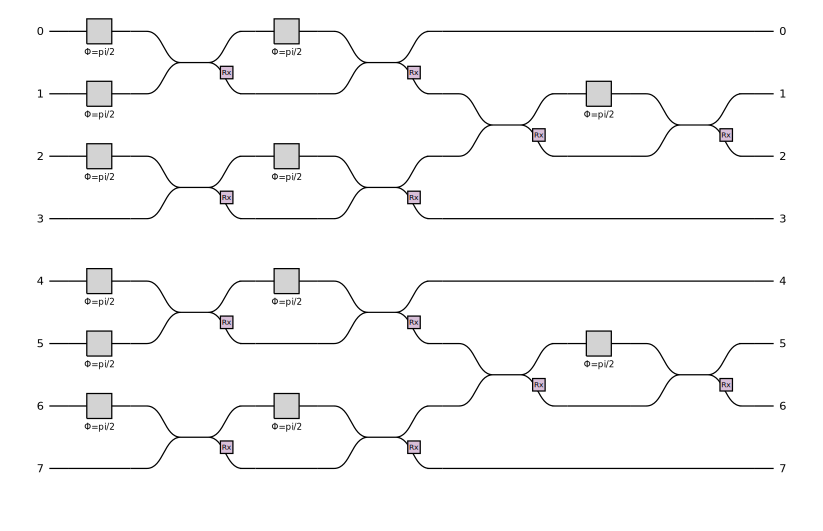

In [15]:
#end of generator, beginning of discriminator
# list lines with phase shift
list = [0,1,2,4,5,6]
my_disc = pcvl.Circuit(8)

for i in list:
    my_disc.add(i, comp.PS(sp.pi/2))

my_disc.add((0, 1), comp.BS())
my_disc.add((2, 3), comp.BS())
my_disc.add((4, 5), comp.BS())
my_disc.add((6, 7), comp.BS())

# list lines with phase shift
list = [0,2,4,6]
for i in list:
    my_disc.add(i, comp.PS(sp.pi/2))


my_disc.add((0, 1), comp.BS())
my_disc.add((2, 3), comp.BS())
my_disc.add((4, 5), comp.BS())
my_disc.add((6, 7), comp.BS())

my_disc.add((1, 2), comp.BS())
my_disc.add((5, 6), comp.BS())

# list lines with phase shift
list = [1,5]
for i in list:
    my_disc.add(i, comp.PS(sp.pi/2))

my_disc.add((1, 2), comp.BS())
my_disc.add((5, 6), comp.BS())

pcvl.pdisplay(my_disc, skin=SymbSkin())

#creating the input to circuit using Perceval StateVector
# sv = pcvl.StateVector("|1,0,0,0,1,0,0,0>") + pcvl.StateVector("|0,1,0,0,0,1,0,0>") + pcvl.StateVector("|0,0,1,0,0,0,1,0>") + pcvl.StateVector("|0,0,0,1,0,0,0,1>")
# print(sv)

In [16]:
# loss function eq 1

def loss(matrix1, matrix2):
    return np.trace(np.dot(matrix1, matrix2))
matrix_shape = (3, 3)
M_theta_D = np.random.rand(*matrix_shape) 
rho_theta_G = np.random.rand(*matrix_shape) 
tau_hat = np.random.rand(*matrix_shape)

trace_M_rho = loss(M_theta_D, rho_theta_G)
trace_M_tau = loss(M_theta_D, tau_hat)

difference = trace_M_rho - trace_M_tau

print(difference)


-0.29454097353834796


In [17]:
# run sampler on generator+disc with provided input

provided_fock_state = pcvl.StateVector("|1,0,0,0,1,0,0,0>") + pcvl.StateVector("|0,1,0,0,0,1,0,0>") + pcvl.StateVector("|0,0,1,0,0,0,1,0>") + pcvl.StateVector("|0,0,0,1,0,0,0,1>")

true_fock_state = pcvl.StateVector("|1,0,0,0,0,1,0,0>") + pcvl.StateVector("|0,1,0,0,0,0,1,0>") + pcvl.StateVector("|0,0,1,0,0,0,0,1>") + pcvl.StateVector("|0,0,0,1,1,0,0,0>")


p = pcvl.Processor("SLOS", my_genDisc)
p.with_input(provided_fock_state)

sampler = pcvl.algorithm.Sampler(p)

samples = 1000

sample_count = sampler.sample_count(samples)

## |0,0,1,0,0,0,1,0>
## 00100010

num_samples_with_22_ququart_state = sample_count['results'].__getitem__(pcvl.BasicState([0,0,1,0,0,0,1,0]))

print("Probability", num_samples_with_22_ququart_state / samples)



# run sampler on disc with true fock state as input



Probability 0.062


In [18]:
# run sampler on generator+disc with provided input

provided_fock_state = pcvl.StateVector("|1,0,0,0,1,0,0,0>") + pcvl.StateVector("|0,1,0,0,0,1,0,0>") + pcvl.StateVector("|0,0,1,0,0,0,1,0>") + pcvl.StateVector("|0,0,0,1,0,0,0,1>")

true_fock_state = pcvl.StateVector("|1,0,0,0,0,1,0,0>") + pcvl.StateVector("|0,1,0,0,0,0,1,0>") + pcvl.StateVector("|0,0,1,0,0,0,0,1>") + pcvl.StateVector("|0,0,0,1,1,0,0,0>")


p = pcvl.Processor("SLOS", my_disc)
p.with_input(true_fock_state)

sampler = pcvl.algorithm.Sampler(p)

samples = 1000

sample_count = sampler.sample_count(samples)

## |0,0,1,0,0,0,1,0>
## 00100010

num_samples_with_22_ququart_state = sample_count['results'].__getitem__(pcvl.BasicState([0,0,1,0,0,0,1,0]))

print("Probability", num_samples_with_22_ququart_state / samples)



# run sampler on disc with true fock state as input



Probability 0.0


In [19]:
import random
import math

def generate_random_radians(length):
    radians = []
    for _ in range(length):
        radians.append(comp.PS(random.uniform(0, 2*math.pi)))
    return radians

# Example usage:
length = 5
random_radians = generate_random_radians(length)
print(random_radians)


[<perceval.components.unitary_components.PS object at 0x15fede890>, <perceval.components.unitary_components.PS object at 0x15f8b3210>, <perceval.components.unitary_components.PS object at 0x15fedf450>, <perceval.components.unitary_components.PS object at 0x15f8e23d0>, <perceval.components.unitary_components.PS object at 0x15f837750>]
